# Earthworks: Gully Modeling

Brendan Harmon  
2025-07-02

<figure>
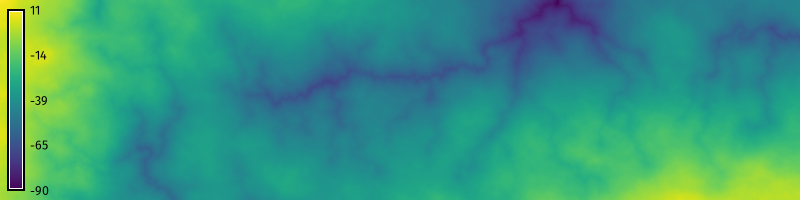
<figcaption aria-hidden="true">Gullies</figcaption>
</figure>

Learn the how to model gullies using relative cut operations with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html).
This tutorial introduces more features of
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
including vector line input, relative operations, exponential functions,
and volumetric change calculations. While absolute operations calculate
cut and fill based on a vertical datum of zero and can be used to model
features at a given elevation, relative operations calculate cut and
fill relative to the existing topography and can be used to model
features that follow the existing terrain.

Use a relative earthworking operation with an exponential function to
carve deep gullies into a landscape. In this tutorial all of the data
will be created procedurally including the terrain and the streams.
Start by generating fractal terrain. Then model flow accumulation
through the fractal terrain and extract its stream network. Finally use
the vector map of streams as input for a relative cut operation to
transform valleys into deep gullies. This tutorial covers:

-   Terrain generation
-   Flow accumulation
-   Stream extraction
-   Relative earthworks

For a simulation based approach to modeling gullies, try the landscape
evolution model
[r.sim.terrain](https://grass.osgeo.org/grass-stable/manuals/addons/r.sim.terrain.html)
instead.

# Setup

## Project

Start a GRASS session in a new project with a Cartesian (XY) coordinate
system.

In [1]:
# Import libraries
import os
import sys
import subprocess
from pathlib import Path

# Find GRASS Python packages
sys.path.append(
  subprocess.check_output(
    ["grass", "--config", "python_path"],
    text=True
    ).strip()
  )

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Create a temporary folder
import tempfile
temporary = tempfile.TemporaryDirectory()

# Create a project in the temporary directory
gs.create_project(path=temporary.name, name="xy")

# Start GRASS in this project
session = gj.init(Path(temporary.name, "xy"))

## Installation

Install
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
and
[r.stream.order](https://grass.osgeo.org/grass-stable/manuals/addons/r.stream.order.html)
with
[g.extension](https://grass.osgeo.org/grass-stable/manuals/g.extension.html).

## Python

In [2]:
# Install extension
gs.run_command("g.extension", extension="r.earthworks")
gs.run_command("g.extension", extension="r.stream.order")

## Region

Use
[g.region](https://grass.osgeo.org/grass-stable/manuals/g.region.html)
to set the extent and resolution of the computational region. Create a
region starting at the origin and extending two hundred units north and
eight hundred units east.

In [3]:
# Set region
gs.run_command("g.region", n=200, e=800, s=0, w=0, res=1)

# Fractal Terrain

Generate a fractal terrain with
[r.surf.fractal](https://grass.osgeo.org/grass-stable/manuals/r.surf.fractal.html).
Running this tool without setting a seed will generate random results
each run. For reproducible results set a seed. Then use the raster
calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to scale it vertically so that the mountains are not too high.

In [4]:
# Generate fractal surface
gs.run_command(
    "r.surf.fractal",
    output="fractal",
    seed=1
    )
gs.mapcalc("fractal = fractal / 10")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="fractal")
m.d_legend(raster="fractal", at=(5, 95, 1, 3))
m.show()

<figure>
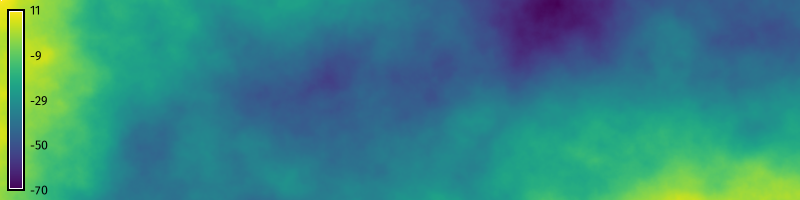
<figcaption aria-hidden="true">Fractal terrain</figcaption>
</figure>

# Stream Network

Model a stream network for the fractal landscape. First use
[r.watershed](https://grass.osgeo.org/grass-stable/manuals/r.watershed.html)
to compute flow accumulation through the landscape. Then use
[r.stream.extract](https://grass.osgeo.org/grass-stable/manuals/r.stream.extract.html)
to extract a vector stream network. Try different `threshold` values to
experiment with the minimum flow accumulation required for streams.
Calculate the hierarchy of the stream network with
[r.stream.order](https://grass.osgeo.org/grass-stable/manuals/addons/r.stream.order.html).
Use map algebra with
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to estimate the depth of gullies by scaling the resulting Strahler
stream order raster map. Use a negative scaling factor.

In [5]:
# Compute flow accumulation
gs.run_command(
    "r.watershed",
    elevation="fractal",
    accumulation="accumulation",
    flags='b'
    )

# Extract stream network
gs.run_command("r.stream.extract",
    elevation="fractal",
    accumulation="accumulation",
    threshold=1000,
    stream_vector="streams",
    stream_raster="streams",
    direction="direction"
    )

# Calculate stream order
gs.run_command("r.stream.order",
    elevation="fractal",
    accumulation="accumulation",
    stream_rast="streams",
    stream_vect="streams",
    direction="direction",
    strahler="strahler"
    )

# Scale raster
gs.mapcalc("gullies = strahler * -5")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="fractal")
m.d_vect(map="streams", type="line", color="white", width_column="strahler")
m.d_legend(raster="fractal", at=(5, 95, 1, 3))
m.show()

<figure>
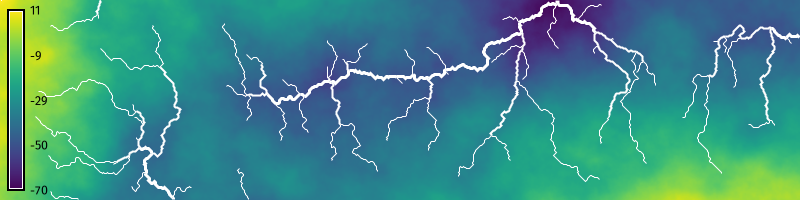
<figcaption aria-hidden="true">Stream network</figcaption>
</figure>

# Relative Cut Operation

Use
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
to cut deep gullies into the stream channels. Use the exponential growth
and decay function $z = z_0 e^{-\lambda \sqrt{\Delta x^2 + \Delta y^2}}$
to model the steep slopes of the gullies. Set `mode` to relative,
`operation` to cut, `function` to exponential, `raster` to the raster
map of gullies, `z` to a negative value, and `exponential` $\lambda$ to a value
such as 0.1. Save an output `volume` raster to visualize volumetric
change. This may take a minute to run. For faster results, try setting a
lower resolution with
[g.region](https://grass.osgeo.org/grass-stable/manuals/g.region.html).

In [6]:
# Model gullies
gs.run_command(
    "r.earthworks",
    elevation="fractal",
    earthworks="gullies",
    volume="volume",
    mode="relative",
    operation="cut",
    function="exponential",
    raster="gullies",
    exponential=0.1
    )
gs.run_command("r.colors", map="volume", color="inferno")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="gullies")
m.d_legend(raster="gullies", at=(5, 95, 1, 3))
m.show()

# Visualize volume
m = gj.Map(width=800)
m.d_rast(map="volume")
m.d_legend(raster="volume", at=(5, 95, 1, 3))
m.show()

<figure>
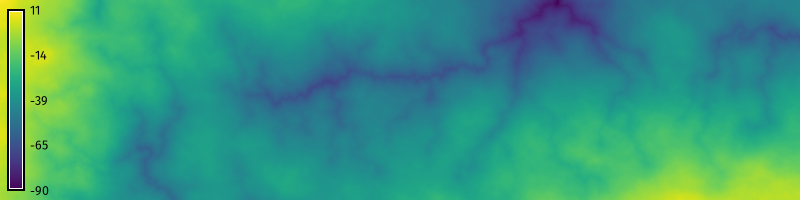
<figcaption aria-hidden="true">Gullies</figcaption>
</figure>

<figure>
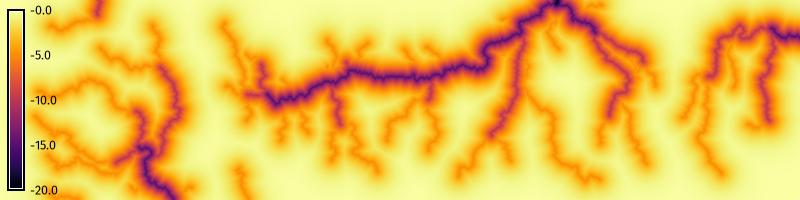
<figcaption aria-hidden="true">Volumetric change</figcaption>
</figure>